# Video classification with Tensorflow

- Downloading Dataset - UCF101
- Trimming Dataset videos
- Dataset Preprocessing
- Model creation
- Model training
- Testing on test data
- Save and download model
- Inference code for testing on single Video


# Downloading Dataset


## Imports

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import random
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile
import pandas as pd
from keras import backend as K
import sys
import csv
import os
from os.path import exists
import cv2
import math
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from google.colab import drive
import gc

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

## Define root paths accordingly


In [3]:
data_root = '/content/drive/MyDrive/video_classification/dataset/'
folder_root = '/content/drive/MyDrive/video_classification/'

## Mount drive

In [4]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Add the video classnames


In [5]:
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
Videos = {}
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()
if not exists(folder_root): os.mkdir(folder_root)
if not exists(data_root): os.mkdir(data_root)

classnames = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam", "BandMarching", "BaseballPitch", "BasketballShooting", "BasketballDunk", "BenchPress", "Biking", "BilliardsShot", "BlowDryHair", "BlowingCandles", "BodyWeightSquats", "Bowling", "BoxingPunchingBag", "BoxingSpeedBag", "Breaststroke", "BrushingTeeth", "CleanandJerk", "CliffDiving", "CricketBowling", "CricketShot", "CuttingInKitchen", "Diving", "Drumming", "Fencing", "FieldHockeyPenalty", "FloorGymnastics", "FrisbeeCatch", "FrontCrawl", "GolfSwing", "Haircut", "HammerThrow", "Hammering", "HandstandPushups", "HandstandWalking", "HeadMassage", "HighJump", "HorseRace", "HorseRiding", "HulaHoop", "IceDancing", "JavelinThrow", "JugglingBalls", "JumpRope", "JumpingJack", "Kayaking", "Knitting", "LongJump", "Lunges", "MilitaryParade", "MixingBatter", "MoppingFloor", "Nunchucks", "ParallelBars", "PizzaTossing", "PlayingGuitar", "PlayingPiano", "PlayingTabla", "PlayingViolin", "PlayingCello", "PlayingDaf", "PlayingDhol", "PlayingFlute", "PlayingSitar", "PoleVault", "PommelHorse", "PullUps", "Punch", "PushUps", "Rafting", "RockClimbingIndoor", "RopeClimbing", "Rowing", "SalsaSpins", "ShavingBeard", "Shotput", "SkateBoarding", "Skiing", "Skijet", "SkyDiving", "SoccerJuggling", "SoccerPenalty", "StillRings", "SumoWrestling", "Surfing", "Swing", "TableTennisShot", "TaiChi", "TennisSwing", "ThrowDiscus", "TrampolineJumping", "Typing", "UnevenBars", "VolleyballSpiking", "Walkingwithadog", "WallPushups", "WritingOnBoard", "YoYo"]

v = np.random.choice(classnames, size=10).tolist()

for classname in v:
  if not exists(data_root+classname): os.mkdir(data_root+classname)
print('The directory structure is created.')
def list_ucf_videos():
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    
    for i in v:
      s = "(v_"+str(i)+"[\w_]+\.avi)"
      videos = re.findall(s, index)
      Videos[i]=sorted(set(videos))
  return Videos

The directory structure is created.


In [6]:
unverified_context = ssl._create_unverified_context()
def fetch_ucf_video(video):
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

## Download videos


In [7]:
V = {}
unverified_context = ssl._create_unverified_context()
V = list_ucf_videos()
for i,value in V.items():
  _VIDEO_LIST = V[i]
  _CACHE_DIR = "/content/drive/MyDrive/video_classification/dataset/" + str(i) + "/"
  for j in _VIDEO_LIST:  
    video_path = fetch_ucf_video(j)

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g01_c01.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g01_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g01_c02.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g01_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g01_c03.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g01_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g01_c04.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g01_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g02_c01.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g02_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Skijet_g02_c02.avi => /content/drive/MyDrive/video_classification/dataset/Skijet/v_Skijet_g02_c02.avi
Fetching https://www.crcv.ucf.edu/

In [8]:
gc.collect()

1050

# CSV creation

In [9]:
with open(folder_root+'dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for c in v:
    path = os.path.join(data_root, c+"/")
    for i in os.listdir(path):
      writer.writerow([v.index(c), os.path.join(path, i)])

## Shuffle CSV data


In [10]:
# shuffle the data in csv
df = pd.read_csv(folder_root+'dataset.csv')
ds = df.sample(frac=1)
ds.to_csv(folder_root+'dataset.csv', index=False)

In [11]:
# split the data into train and test

import numpy as np
df = pd.read_csv(folder_root+'dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

In [12]:
train.to_pickle(data_root+'train.pkl')
test.to_pickle(data_root+'test.pkl')

## Define hyperparameters
* batch size
* epochs
* max sequence length
* number of features
* image size

In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

Count of training and test videos :

In [14]:
train_df = train
test_df = test

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(30)

Total videos for training: 876
Total videos for testing: 220


class                                               path
78       2  /content/drive/MyDrive/video_classification/da...
945      8  /content/drive/MyDrive/video_classification/da...
790      8  /content/drive/MyDrive/video_classification/da...
192      8  /content/drive/MyDrive/video_classification/da...
469      9  /content/drive/MyDrive/video_classification/da...
158      1  /content/drive/MyDrive/video_classification/da...
1085     9  /content/drive/MyDrive/video_classification/da...
944      3  /content/drive/MyDrive/video_classification/da...
143      4  /content/drive/MyDrive/video_classification/da...
970      2  /content/drive/MyDrive/video_classification/da...
822      8  /content/drive/MyDrive/video_classification/da...
723      8  /content/drive/MyDrive/video_classification/da...
986      3  /content/drive/MyDrive/video_classification/da...
971      2  /content/drive/MyDrive/video_classification/da...
835      2  /content/drive/MyDrive/video_classification/da...
934      1  /content/drive/MyDrive/video_classification/da...
640      9  /content/drive/MyDrive/video_classification/da...
1043     0  /content/drive/MyDrive/video_classification/da...
179      9  /content/drive/MyDrive/video_classification/da...
169      0  /content/drive/MyDrive/video_classification/da...
622      0  /content/drive/MyDrive/video_classification/da...
396      2  /content/drive/MyDrive/video_classification/da...
321      6  /content/drive/MyDrive/video_classification/da...
149      8  /content/drive/MyDrive/video_classification/da...
861      9  /content/drive/MyDrive/video_classification/da...
865      6  /content/drive/MyDrive/video_classification/da...
464      9  /content/drive/MyDrive/video_classification/da...
757      2  /content/drive/MyDrive/video_classification/da...
657      1  /content/drive/MyDrive/video_classification/da...
407      2  /content/drive/MyDrive/video_classification/da...

# Utility functions



In [15]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    j = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [16]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


Encode labels as integers:

In [17]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"])
)
print(label_processor.get_vocabulary())

['0', '1', '2', '3', '4', '6', '7', '8', '9']


In [18]:
gc.collect()

12868

# Dataset preprocessing


In [19]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    print(f"Preparing {len(video_paths)} videos...")

    # for each video:
    for idx,path in enumerate(video_paths):
        # gather all its frames
        frames = load_video(path)
        frames = frames[None, ...]

        gc.collect()

        # store the masks and features of the current video
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # extract features from the frames of the current video
        for i, batch in enumerate(frames):
            try:
              video_length = batch.shape[1]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
              temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
              frame_features[idx,] = temp_frame_featutes.squeeze()
              frame_masks[idx,] = temp_frame_mask.squeeze()
            except:
              pass

        gc.collect()
        print(idx)

    return (frame_features, frame_masks), labels

gc.collect()

train_data, train_labels = prepare_all_videos(train_df)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Preparing 876 videos...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
27

In [20]:
gc.collect()

50

Preparing test data :


In [21]:
test_data, test_labels = prepare_all_videos(test_df)

Preparing 220 videos...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


## Download pretrained Resnet50 model

In [ ]:
input_tensor = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = ResNet50(weights="imagenet", include_top=False,input_tensor=input_tensor, input_shape=(IMG_SIZE, IMG_SIZE, 3))

top = Dense(11, activation='softmax')(
            Dropout(0.5)(
                Dense(2048, activation='relu')(
                    Dropout(0.5)(
                        GlobalAveragePooling2D()(base.output)
                    )
                )
            )
        )

model = Model(input_tensor, top)

In [ ]:
# sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.LSTM(200, return_sequences=True)(
        frame_features_input, mask=mask_input
    )

    x = keras.layers.LSTM(200, return_sequences=True)(x)

    x = keras.layers.GRU(20)(x)

    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dense(1024, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [32]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True


In [33]:
model.compile(keras.optimizers.Adam(lr=10e-5),loss = 'categorical_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
gc.collect()

168806

# Model training

In [27]:
def run_training():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_training()

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 2.0653 - accuracy: 0.1843
Epoch 1: val_loss improved from inf to 2.41907, saving model to /tmp/video_classifier
20/20 [==============================] - 40s 1s/step - loss: 2.0653 - accuracy: 0.1843 - val_loss: 2.4191 - val_accuracy: 0.2471
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.3883
Epoch 2: val_loss improved from 2.41907 to 1.29580, saving model to /tmp/video_classifier
20/20 [==============================] - 25s 1s/step - loss: 1.5743 - accuracy: 0.3883 - val_loss: 1.2958 - val_accuracy: 0.4411
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.4959
Epoch 3: val_loss improved from 1.29580 to 0.96117, saving model to /tmp/video_classifier
20/20 [==============================] - 24s 1s/step - loss: 1.2323 - accuracy: 0.4959 - val_loss: 0.9612 - val_accuracy: 0.6084
Epoch 4/20
20/20 [==============================] - ETA: 0s - los

Save the trained model

In [ ]:
sequence_model.save(folder_root+'saved_model')

Load the saved model


In [ ]:
sequence_model = keras.models.load_model(folder_root+'saved_model')

## Inference code for testing on single video


In [ ]:
import imageio
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {str(v[class_vocab[i].astype(int)])} :{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
        
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: /content/drive/MyDrive/video_classification/dataset/JugglingBalls/v_JugglingBalls_g18_c04.avi
  JugglingBalls :9: 98.07%
  PizzaTossing :4:  1.81%
  BlowDryHair :1:  0.11%
  Skijet :3:  0.00%
  PushUps :6:  0.00%
  Shotput :8:  0.00%
  HighJump :7:  0.00%
  MilitaryParade :0:  0.00%
  SoccerPenalty :2:  0.00%



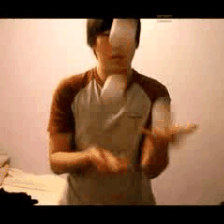

In [36]:
test_video = np.random.choice(test_df["path"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

# References

* https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
* https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5?gi=16eebff0b2aa
* https://keras.io/examples/vision/video_classification/
* https://github.com/sayakpaul
* https://github.com/akshitadixit